In [69]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from scipy import ndimage
import math

In [70]:
pixelReplace = 1
pourcentage = 8
taille_fenetre = 800


id_patient = 1
path = 'C:/Users/Sanchez/Documents/JFR/DATA/patient_' + str(id_patient)

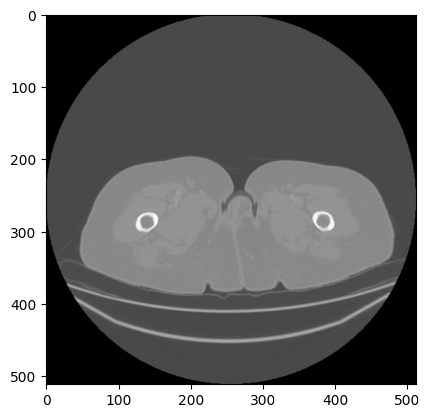

In [81]:
fichiers_dicom = [os.path.join(path, fichier) for fichier in os.listdir(path) if fichier.endswith('.dcm')]
fichiers_dicom.sort(key=lambda x: pydicom.dcmread(x).InstanceNumber)

nombre_de_fichiers = len(fichiers_dicom)
nombre_a_afficher = int(nombre_de_fichiers * (pourcentage / 100))

derniers_fichiers_dicom = []
for fichier in fichiers_dicom[-nombre_a_afficher:]:
    dernier_fichier = pydicom.dcmread(fichier)
    derniers_fichiers_dicom.append(dernier_fichier.pixel_array)

plt.imshow(derniers_fichiers_dicom[len(derniers_fichiers_dicom)//2], cmap= 'gray')
plt.show()

In [72]:
def cancelNoise(dicomImage, print=False):
    taille_fenetre = 35
    nouvelle_image = np.copy(dicomImage)
    image = dicomImage
    couleur_fond = image.min()
    
    #preprocess 
    if couleur_fond == -2000 :
        nouvelle_image[nouvelle_image < 500] = couleur_fond
    if couleur_fond == -2048 :
        nouvelle_image[nouvelle_image < -500] = couleur_fond
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if nouvelle_image[i, j] > 500:
                fenetre = nouvelle_image[i - taille_fenetre // 2:i + taille_fenetre // 2 + 1,
                                         j - taille_fenetre // 2:j + taille_fenetre // 2 + 1]
                pixels_noirs = np.sum(fenetre <= couleur_fond)
                if pixels_noirs > taille_fenetre * taille_fenetre * 0.65:
                    nouvelle_image[i, j] = couleur_fond  

    final_image = nouvelle_image.astype("float32")
    final_image /= np.max(final_image)
    final_image = cv2.cvtColor(final_image, cv2.COLOR_GRAY2RGB)
    
    final_image[final_image < 0.6] = 0

    if print :
        plt.imshow(final_image, cmap="gray")
        plt.show()
    
    return final_image

derniers_fichiers_dicom_WT_Noise =  list(map(cancelNoise, derniers_fichiers_dicom))

print(len(derniers_fichiers_dicom_WT_Noise))

47


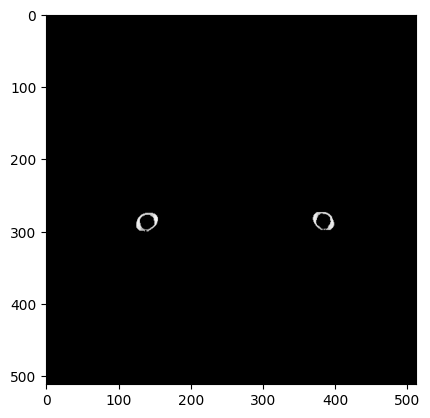

In [73]:
plt.imshow(derniers_fichiers_dicom_WT_Noise[len(derniers_fichiers_dicom_WT_Noise)//2], cmap= 'gray')
plt.show()

In [74]:
def create_video(lsit):
    nom_video_sortie = 'video_patient' + str(id_patient) + '.avi'
    codec = cv2.VideoWriter_fourcc(*'XVID')
    fps = 10  
    largeur, hauteur = pydicom.dcmread(fichiers_dicom[0]).pixel_array.shape
    video_writer = cv2.VideoWriter(nom_video_sortie, codec, fps, (largeur, hauteur))

    for image in lsit:
        image = (image / np.max(image) * 255).astype(np.uint8)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Convertissez en image couleur
        video_writer.write(image)

    video_writer.release()

def color_bone(x, max_pixel):
        if x > max_pixel - 2000 :
            return pixelReplace
        else :
            return 0

def nb_bone(matrice):
    etiquettes, nombre_de_formes = ndimage.label(matrice > 0.6)
    res = []
    for i in range(1, nombre_de_formes + 1):  
        pixels_forme = (etiquettes == i)
        coordonnees_pixels = np.argwhere(pixels_forme)
        if len(coordonnees_pixels) < 300 :
            continue

        centre_x = np.mean(coordonnees_pixels[:, 0])
        centre_y = np.mean(coordonnees_pixels[:, 1])
        
        etiquettes[int(centre_x)][int(centre_y)] = pixelReplace 

        #print(f"Centre de la forme {i} : ({centre_x}, {centre_y})")
        res.append((centre_x, centre_y))


    return res

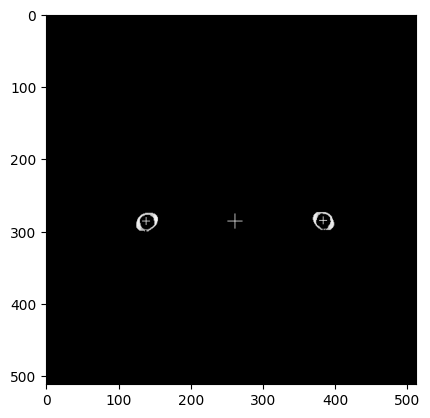

In [75]:
Bone_Image = []
for fichier in derniers_fichiers_dicom_WT_Noise:
    image_matrice = fichier
    mean_pixel, max_pixel = np.mean(image_matrice), np.max(image_matrice)
    new_image =  image_matrice
    femur_center = nb_bone(image_matrice)

    for x,y in femur_center:
        for i in range(-5, 6):
            new_image[int(x + i)][int(y)] = pixelReplace 
            new_image[int(x)][int(y + i)] = pixelReplace 

    x1,y1 = femur_center[0]
    x2,y2 = femur_center[1]

    x3,y3 = int((x1 + x2) /2), int((y1 + y2)/2 )
    for i in range(-10, 11):
        new_image[int((x1 + x2) /2) + i][int((y1 + y2)/2 )] = pixelReplace 
        new_image[int((x1 + x2) /2)][int((y1 + y2)/2 ) + i] = pixelReplace 
    Bone_Image.append(new_image)

plt.imshow(Bone_Image[len(Bone_Image)//2])
plt.show()


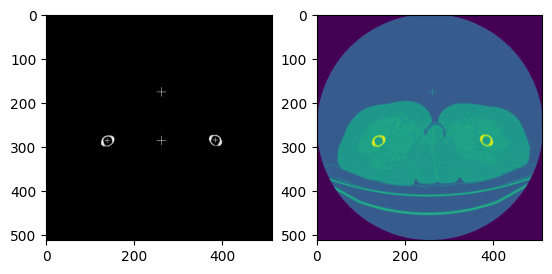

In [83]:
res = []
for new_image in Bone_Image:
    dx = x2 - x1
    dy = y2 - y1
    d = -110
    norme = math.sqrt(dx**2 + dy**2)

    # Normalisation du vecteur 
    ux = dx / norme
    uy = dy / norme

    vx = -uy
    vy = ux

    vx *= d
    vy *= d

    x = x3 + vx
    y = y3 + vy

    for i in range(-10, 11):
            new_image[int(x + i)][int(y)] = pixelReplace 
            new_image[int(x)][int(y + i)] = pixelReplace 
    res.append((new_image,(x, y)))


image, center = res[len(res)//2]
plt.figure()

plt.subplot(1,2, 1)
plt.imshow(image)
plt.subplot(1,2, 2)


image_cross = np.copy(derniers_fichiers_dicom[len(res)//2])
for i in range(-10, 11):
            image_cross[int(x + i)][int(y)] = pixelReplace 
            image_cross[int(x)][int(y + i)] = pixelReplace 
plt.imshow(image_cross)
plt.show()


6
FEMME


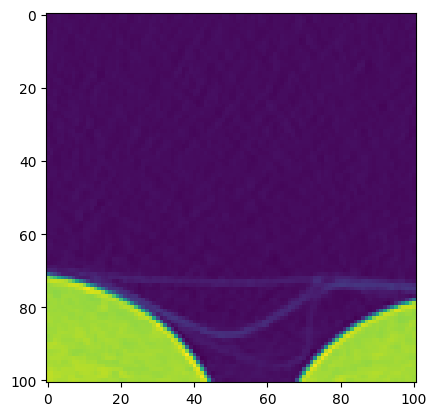

In [84]:
taille_f = 100 # pixels = taille_f **2 
image = derniers_fichiers_dicom[len(res)//2 ]
fenetre = image[int(x - taille_f // 2) : int(x + taille_f // 2 + 1),
            int(y - taille_f // 2 ): int(y + taille_f // 2 + 1)]

pixels_blanc = np.sum(fenetre > 0)
print(pixels_blanc)
if pixels_blanc > 5000 :
    print("HOMME")
else:
    print("FEMME")
plt.imshow(fenetre)
plt.show()
